Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import scipy.fftpack as sf
import scipy.linalg as sl
import numpy as np


In [2]:
%load_ext fortranmagic

/usr/local/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


# Introduction

Python poss\`ede un certain nombre d'avantages :
- Langage simple, interpr\'et\'e avec une syntaxe claire.
- Facile \`a programmer et la gestion de la m\'emoire est automatique.
- Open source, gratuit et portable.
- Dispose de nombreux modules pour le calcul scientifique.



Il est n\'eanmoins trop lent pour les taches num\'eriques intensives. Dans ce cas on peut l'interfacer avec C ou Fortran. 
Cette technique permet d'utiliser le meilleur des deux mondes:
- Taches de pr\'e et post-traitement en Python.
- Parties num\'eriques intensives en Fortran (ou C) 

# f2py
f2py est fourni avec Numpy et trois m\'ethodes pour cr\'eer une interface sont propos\'ees :
- Interfacer des subroutines simples sans \'ecrire de code suppl\'ementaire.
- Ajouter des directives pour f2py dans le source Fortran pour un interfa\c{c}age plus complexe.
- \'Ecrire un fichier d'interface d\'ecrivant les subroutines et les donn\'ees \`a interfacer. f2py g\'en\`ere automatiquement un fichier d'interface simple qu'on peut ensuite \'editer et modifier. 

# Exemple de subroutine simple
   
## Calcul de la norme.
   
### Fortran 90/95 format libre

In [3]:
%%file norme.f90
subroutine norme (a, b, c)
real(8), intent(in) :: a, b
real(8), intent(out) :: c 
c =	sqrt (a*a+b*b) 
end subroutine norme

Overwriting norme.f90


### Fortran 77 format fixe

In [4]:
%%file norme.f
      subroutine norme (a, b, c)
      real*8 a,b,c
Cf2py intent(out) c
      c = sqrt (a*a+b*b) 
      end 

Overwriting norme.f


# Compilation et ex\'ecution

## G\'en\'eration de l'interface Python avec f2py


In [5]:
!f2py -c norme.f90 -m vect  --fcompiler=gnu95 --f90flags=-O3

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "vect" sources
f2py options: []
f2py:> /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpsolg3jud/src.macosx-10.12-x86_64-3.6/vectmodule.c
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpsolg3jud/src.macosx-10.12-x86_64-3.6
Reading fortran codes...
	Reading file 'norme.f90' (format:free)
Post-processing...
	Block: vect
			Block: norme
Post-processing (stage 2)...
Building modules...
	Building module "vect"...
		Constructing wrapper function "norme"...
		  c = norme(a,b)
	Wrote C/API module "vect" to file "/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpsolg3jud/src.macosx-10.12-x86_64-3.6/vectmodule.c"
  adding '/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpsolg3jud/src.macosx-10.12-x86_64-3.6/fortra

Appel depuis un shell Python

In [6]:
import os
#os.environ['LD_LIBRARY_PATH'] = "/usr/local/lib/python3.6/site-packages/scipy/.dylibs/"
import vect
c = vect.norme(3,4)
c

5.0

In [7]:
#Documentation g\'en\'er\'ee automatiquement par f2py

print(vect.norme.__doc__)


c = norme(a,b)

Wrapper for ``norme``.

Parameters
----------
a : input float
b : input float

Returns
-------
c : float



# Ajout de directive f2py dans le source Fortran
Ces ajouts dans le code source fortran permettent  de pr\'eciser le r\^ole et la d\'efinition des variables d'entr\'es-sorties. Sont utilis\'es:
- Les attributs du F90.
- Les attributs sp\'ecifiques.py f2py.

In [8]:
%%fortran 
subroutine norme(a,c,n) 
integer :: n 
real(8),dimension(n),intent(in) :: a
!f2py optional , depend(a) :: n=len(a)
real(8),intent(out) :: c 
real(8) :: sommec 
integer :: i
sommec = 0 
do i=1,n
   sommec=sommec+a( i )*a( i ) 
end do
c=sqrt (sommec) 
end subroutine norme

# Liste Python ou tableau numpy en argument

In [9]:
a=[2,3,4]  # Une liste Python
type(a)

list

In [10]:
norme(a)

5.385164807134504

In [11]:
from numpy import * 
a=arange(2,5)  # Un tableau numpy
type(a)


numpy.ndarray

In [12]:
norme(a) 

5.385164807134504

In [13]:
print(norme.__doc__) # Documentation

c = norme(a,[n])

Wrapper for ``norme``.

Parameters
----------
a : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: len(a)

Returns
-------
c : float



# Utilisation d'un fichier signature

- On peut g\'en\'erer automatiquement un fichier signature
```bash
f2py vecteur.f90 -h vecteur.pyf
```
- Contennu de vecteur.pynu de vecteur.pyf

```fortran
!    -*- f90 -*-
! Note: the context of this file is case sensitive.

subroutine norme(a,c,n) ! in norme.f90
    real(kind=8) dimension(n),intent(in) :: a
    real(kind=8) intent(out) :: c
    integer optional,check(len(a)>=n),depend(a) :: n=len(a)
end subroutine norme

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/
```


# Appel d'une fonction Python depuis Fortran

- Possibilité d'utiliser une fonction issue d'un calcul symbolique (module  python sympy)



In [16]:
%%fortran
subroutine sommef (f ,n,s) 
!Calcule la somme (f(i), i=1,n) 
external f 
integer, intent(in) :: n 
real, intent(out) ::s
s=0.0 
do i=1,n
   s=s+f(i)
end do 
end subroutine sommef

In [17]:
def fonction(i) : return(i*i) 
sommef(fonction,3) 


14.0

In [18]:
sommef(lambda x :x**3,3) 

36.0

In [19]:
# Les tableaux multi dimensionnels


In [23]:
%%fortran --extra "-DF2PY_REPORT_ON_ARRAY_COPY=1"
subroutine move( positions, vitesses, dt, n)
integer, intent(in) :: n
real(8), intent(in) :: dt
real(8), dimension(n,3), intent(in) :: vitesses
real(8), dimension(n,3) :: positions
do i = 1, n
  positions(i,:) = positions(i,:) + dt*vitesses(i,:)
end do
end subroutine move


In [27]:
positions = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
vitesses = [[0, 1, 2], [0, 3, 2], [0, 1, 3]]

In [28]:

move(positions, vitesses, 0.1)
positions #le tableau n'est pas mis a jour, stockage C


[[0, 0, 0], [0, 0, 0], [0, 0, 0]]

In [30]:
positions = np.array(positions, dtype='f8', order='F')
move(positions, vitesses, 0.1)
positions #le tableau est modifie, stockage Fortran 

array([[ 0. ,  0.1,  0.2],
       [ 0. ,  0.3,  0.2],
       [ 0. ,  0.1,  0.3]])

# Quelques directives
- $optional, required$. Cet attribut est automatique lorsqu'un argument poss\`ede une valeur par d\'efaut.
- $intent(in | inout | out | hide)$ , $intent(in)$ par d\'efaut.
- $intent(out)$ devient automatiquement $intent(out,hide) $.
- $intent(copy)$ et $intent(overwrite)$ permet de contr\^oler les changements dans les arguments d'entr\'ee.
- $check$ permet de v\'erifier les arguments. Souvent g\'er\'e automatiquement par f2py.
- $depend$:  f2py d\'etecte les d\'ependances cycliques.
- $allocatable, parameter$
- $intent(callback), external$: pour les arguments de type fonction.
- $intent(c)$ argument de type C, tableau ou fonction.
- Expressions C: $rank, shape, len, size, slen.$


# distutils

## Exemple de setup.py
```python
#!/usr/bin/env python
from numpy.distutils.core import Extension
ext1 = Extension(name = 'scalar',
                 sources = ['scalar.f'])
ext2 = Extension(name = 'fib2',
                 sources = ['fib2.pyf','fib1.f'])
if __name__ == "__main__":
    from numpy.distutils.core import setup
    setup(name = 'f2py_example', ext_modules = [ext1,ext2])

```

# Appel d'une fonction lapack avec F2PY
```bash
f2py -m mylapack -h degmm.pyf dgemm.f
```
```fortran
python module mylapack ! in 
interface  ! in :mylapack
subroutine dgemm(transa,transb,m,n,k,alpha,a,lda,b,ldb,beta,c,ldc) 
character*1 :: transa, transb
integer :: m, n, k
double precision :: alpha, beta
double precision dimension(lda,*) :: a
integer optional,check(shape(a,0)==lda),depend(a) :: lda=shape(a,0)
double precision dimension(ldb,*) :: b
integer optional,check(shape(b,0)==ldb),depend(b) :: ldb=shape(b,0) 
double precision dimension(shape(a,0),shape(b,1)), intent(out) :: c
integer optional,check(shape(c,0)==ldc),depend(c) :: ldc=shape(c,0)
end subroutine dgemm
end interface 
end python module mylapack
```


# Edition de liens avec lapack
f2py permet d'utiliser une biblioth\`eque \'ecrite en Fortran sans modifier les sources.
```bash
f2py -c degmm.pyf -llapack
```

```python
import numpy 
import mylapack
a = numpy.array([[7,8],[3,4],[1,2]])
b = numpy.array([[1,2,3],[4,5,6]])
c = mylapack.dgemm('N','N',3,2,2,1.0,a,b,1.0)
print c
[[ 39.  54.  69.]
 [ 19.  26.  33.]
 [  9.  12.  15.]]
print numpy.dot(a,b) #fonction numpy pour le produit de matrices
[[39 54 69]
 [19 26 33]
 [ 9 12 15]]

## Les tableaux allou\'es dans le script Python seront allou\'es dans le module Fortran
\begin{fortran}
module f90module
   implicit none
   real(8), dimension(:),   allocatable :: farray
contains
   subroutine init( n ) !Allocation du tableau farray
   integer, intent(in) :: n
   allocate(farray(n))
   end subroutine init
end module f90module
\end{fortran}
\pause
\begin{lstlisting}
f2py -m f90mod -c f90module.f90
\end{lstlisting}
\pause
\begin{python}
>>> import f90mod as F
>>> F.f90module.init(10)
>>> len(F.f90module.farray)
10
\end{python}
\end{frame}



\begin{frame}[fragile]{Les tableaux allou\'es dans le module Fortran seront allou\'es dans le script Python}
\begin{fortran}
module f90module
   implicit none
   real(8), dimension(:),   allocatable :: farray
contains
   subroutine test_array()
   print*, allocated(farray), size(farray)
   end subroutine test_array
end module f90module
\end{fortran}
\pause
\begin{lstlisting}
f2py -m f90mod -c f90module.f90
\end{lstlisting}
\pause
\begin{python}
>>> import numpy
>>> import f90mod
>>> f90mod.f90module.farray = numpy.random.rand(10).astype(numpy.float64)
>>> f90mod.f90module.test_array()
 T          10
\end{python}

\end{frame}

\begin{frame}[fragile]{Encapsulation de donn\'ees Fortran dans une classe Python}
\begin{fortran}
module f90module
   real(8), dimension(:),   allocatable :: masses
   real(8), dimension(:,:),   allocatable :: positions, velocities
contains
 subroutine init_data( n )
 ...
 end subroutine init_data
 
 subroutine calc_forces( forces, n)
 ...
 end subroutine calc_forces
end module f90module
\end{fortran}
\end{frame}

\begin{frame}[fragile]{La classe Python}
\begin{python}
class SolarSystem(object):
   def __init__(self, masses, positions, velocities):
      self.index       = 0
      self.numberof    = len(masses)
      self._masses     = masses
      self._positions  = positions
      self._velocities = velocities
   @property 
   def mass (self):      	  
      return self._masses[self.index]
   @property 
   def position (self):      
      return self._positions[self.index]
   @property 
   def velocity (self):      
      return self._velocities[self.index]
\end{python}
\end{frame}



\begin{frame}[fragile]{Acc\`es aux donn\'ees Fortran}
\begin{python}
>>> import f90mod as F
>>> seystem = SolarSystem(F.f90module.masses, F.f90module.positions,F.f90module.velocities)
>>> system.index = 0
>>> system.mass 
1800262.614350586
>>> system.position 
array([-1.24902032,  0.02831779,  0.04840533])
>>> system.index = 1
>>> system.mass 
0.29846375576171874
>>> system.position 
array([-54.8958322, -34.85936287,-13.02314489])
\end{python}
\end{frame}

\begin{frame}[fragile]{Encapsulation de donn\'ees Fortran dans une classe Python}
\begin{python}
class SolarSystemList(object):
   def __init__(self, solarsystem):
      self.solarsystem = solarsystem
      self.numberof = solarsystem.numberof
   def __getitem__(self, index): 
      self.solarsystem.index = index 
      return self.solarsystem
   def __len__(self): 
      return self.numberof
   def __iter__(self): 
      for i in xrange(self.numberof):
         self.solarsystem.index=i
         yield self.solarsystem
\end{python}
\end{frame}

\begin{frame}[fragile]{Encapsulation de donn\'ees Fortran dans une classe Python}
\begin{python}
>>> systemList = SolarSystemList(system)
>>> systemList[0].mass
1800262.614350586
>>> systemList[0].position 
array([-1.24902032,  0.02831779,  0.04840533])
\end{python}
\pause
Nous pouvons ajouter des fonctions (conversion, nouvelles caract\'eristiques, representation graphique,...)
\begin{python}
class MySolarSystem(SolarSystem):
    def density(self):
        return self.mass / ( 4./3.*N.pi* self.radius **3)
\end{python}
\pause
\begin{python}
>>>myss = MySolarSystem(F.f90wrap.masses,F.f90wrap.positions, \
...    F.f90wrap.velocities, F.f90wrap.radii)
>>>myssList = SolarSystemList(myss)
>>>print myssList[3].density()
5138322.1813
\end{python}
\end{frame}

\begin{frame}[fragile]{Types d\'eriv\'es Fortran 90}
\begin{fortran}
module mesh
implicit none
type :: geometry
   real(8) :: x0, x1, dx    ! coordinates of origin and grid size
   integer :: nx               ! number of grid points
   real(8), dimension(:), pointer :: xgrid  ! coordinates of points
end type geometry

contains

subroutine create(geom,x0,nx,dx) 
!f2py integer, intent(out) :: geom
type(geometry), pointer :: geom
real(8), intent(in) :: x0, dx
integer, intent(in) :: nx
integer :: i   
allocate(geom)
geom%x0=x0; geom%x1=x0+nx*dx; geom%dx=dx; geom%nx=nx
allocate(geom%xgrid(nx))
do i=1,nx
   geom%xgrid(i)=geom%x0+(i-1)*geom%dx
end do
end subroutine create
\end{fortran}
\end{frame}

\begin{frame}[fragile]{Types d\'eriv\'es Fortran 90}
\begin{fortran}
subroutine view(this)
!f2py integer, intent(in) :: this
type(geometry),pointer :: this
print*, 'nx = ', this%nx
print*, this%x0,this%x1
print*, this%xgrid(:)
end subroutine view

end module mesh
\end{fortran}
\pause
\begin{python}
>>> import test
>>> geom = test.mesh.create(0.0,10,0.1)
>>> test.mesh.view()
>>> test.mesh.view(geom)
 nx =           10
0.00000000000000000       1.0000000000000000         0.0000000000000000      
0.10000000000000001       0.20000000000000001       0.30000000000000004       
0.40000000000000002       0.50000000000000000       0.60000000000000009       
0.70000000000000007       0.80000000000000004       0.90000000000000002     
\end{python}
\end{frame}

# f2py + OpenMP



In [36]:
import os
os.environ['CC'] = 'gcc-7' # for mac users

In [39]:
%%fortran --f90flags "-fopenmp" --extra '-l/usr/local/lib -lgomp'
subroutine hello( )
INTEGER NTHREADS, TID, OMP_GET_NUM_THREADS, OMP_GET_THREAD_NUM
! Fork a team of threads giving them their own copies of variables
!$OMP PARALLEL PRIVATE(NTHREADS, TID)
TID = OMP_GET_THREAD_NUM() ! Obtain thread number
PRINT *, 'Hello World from thread = ', TID
IF (TID .EQ. 0) THEN ! Only master thread does this
  NTHREADS = OMP_GET_NUM_THREADS()
  PRINT *, 'Number of threads = ', NTHREADS
END IF
! All threads join master thread and disband
!$OMP END PARALLEL
end subroutine


RuntimeError: f2py failed, see output

In [67]:
hello()

In [64]:
%f2py_help --link blas

blas_info:
customize UnixCCompiler
C compiler: gcc-7 -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes

creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var/folders
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var/folders/mw
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T
creating /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk
compile options: '-I/usr/local/include -I/usr/include -I/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/include -c'
gcc-7: /var/folders/mw/nwq5qyg56fl585pb9jw81_qc0000gn/T/tmpndgicadk/source.c

In [58]:
hello()
 

NameError: name 'hello' is not defined

\begin{frame}[fragile]
\frametitle{Interface avec C}
\begin{itemize}[<+->]
\item Utilisation obligatoire dÕun fichier signature (qui nÕest en gnral pas ncessaire en Fortran o les directives f2py sont directement prises des dclarations du Fortran ou rajoutes dans le code source.
\item Le nom de la fonction doit tre declar avec intent(c)
\item intent(c) doit tre utilis pour toutes les dclarations de variables, mais peut tre factoris en le mettant sur une ligne seul avant les dclarations de variables.
\item Commande :
\begin{lstlisting}
f2py -c cfuncts.c cfuncts.pyf -m cfuncts
\end{lstlisting}
\end{itemize}
\end{frame}



\begin{frame}[fragile]
\frametitle{Fonctions en langage C}
\lstset{language=C}
\begin{lstlisting}
void depositrho(double* rho,double* fold, int* indx,double* depx,int* indv, 
     double* depv, int nx, int	nv){
 int i,j; 
 double dx,dv; 
 for (i=0; i<nx; i++)
    rho[i] = 0; 
 for (i=0; i<nx; i++){
    for (j=0; j<nv; j++){ 
       dx = depx[i+nx*j]; 
       dv = depv[i+nx*j]; 
       rho[indx[i+nx*j]] += (1-dx)*fold[i+nx*j]; 
       rho[(indx[i+nx*j]+1)%nx]	+= dx*fold[i+nx*j ];
 }}} 
void poisson1d_axi(double* ex, double* rho, double xmin, double dx, int nx)
 { int i; 
   double integral, xi;
   integral =0; 
   ex[nx/2] = 0; 
   xi = 0; 
   for (i=1+ nx/2; i <nx; i++){
      xi += dx; 
      integral += dx*(( xi-dx)*rho[i-1]+xi*rho[i])/2.; 
      ex[i] = integral/xi; 
      ex[nx-i-1] = -ex[i];
}}
\end{lstlisting}
\end{frame}

\begin{frame}[fragile]
\frametitle{Fichier signature}
\begin{fortran}
python module cfuncts 
 interface
  subroutine depositrho(rho,fold ,indx,depx,indv,depv,nx,nv) 
   intent(c)::	depositrho 
   intent(c) 
   integer, intent(in) :: nx,nv
   real*8, dimension(nx,nv),depend(nx,nv),intent(in) :: fold ,depx, 
   real*8, dimension(nx),depend(nx),intent(out) :: rho 
   integer, dimension(nx,nv),depend(nx,nv),intent(in) :: indx,indv
  end subroutine depositrho

  subroutine poisson1d_axi(ex,rho,xmin, dx,nx) 
   intent(c) :: poisson1d_axi 
   intent(c) 
   integer, intent(in) :: nx
   real*8, intent(in) :: xmin, dx 
   real*8, dimension(nx), depend(nx), intent(out) :: ex 
   real*8, dimension(nx), depend(nx), intent(in) :: rho
  end subroutine poisson1d_axi 
 end interface
end python module cfuncts
\end{fortran}
\end{frame}

# Les fonctionalit\'es de F2PY

- Fonctionne avec le F77, le F90 et \'egalement des fonctions C.
- G\`ere les common du F77, les modules du F90 ainsi que les tableaux allou\'es dynamiquement.
- Permet d'appeler des fonctions Python depuis du C ou du Fortran (callback)
- G\`ere les diff\'erences de stockage m\'emoire du C et du Fortran.
- G\'en\`ere la documentation Python
- Compilateurs support\'es: GNU, Portland, Sun, Intel,...
- F2py fait partie int\'egrante de numpy.

## Limites 
- Ne g\`ere pas de mani\`ere simple les types d\'eriv\'ees Fortran et les pointeurs.
- N'est pas compatible avec les dernières fonctionalités du fortran 2003-2008 (classes)
- N'est plus réellement développé

# Ressources
- [Site f2py](http://cens.ioc.ee/projects/f2py2e/)
- [Transparents E. Sonnendr\"ucker](http://calcul.math.cnrs.fr/Documents/Journees/dec2006/python-fortran.pdf)
- [SciPy](http://www.scipy.org/F2py)
- [Documentation Sagemath](http://www.sagemath.org/doc/numerical_sage/f2py.html) 
- [Wiki de l'IRMA](http://www-irma.u-strasbg.fr/irmawiki/index.php/Utilisation_de_F2PY)
- Hans Petter Langtangen.*Python Scripting for Computational Science*. Springer 2004


In [16]:

N=128 # matrix size
# Define grid
x, dx = np.linspace(0,1,N+1, retstep=True)
y  = x[:-1] # periodic in y. Remove periodic point
x  = x[1:-1] # Dirichlet 0 in x. Remove both boundary points
dy = dx

Matrix A is a 1D laplacian along x with homogeneous Dirichlet boundary condition

In [17]:
A=np.ones((2,N),dtype=float)
A[0,:]=A[0,:]*(-1.)/(dx*dx)
A[1,:]=A[1,:]*2./(dx*dx)



Matrix with periodic boundary conditions along y is defined by its eigen values.

In [18]:
c=[2./(dy**2), -1./(dy**2)] 
valp = c[0] + 2*c[1]*np.cos(2*np.pi*np.arange(N)/N)

Define right-hand-side. Note that meshgrid reverses the order, so that F and Uex are of shape (ny,nx)  

In [21]:
X,Y=np.meshgrid(x,y)
Uex=np.sin(pi*X)*np.cos(2*np.pi*Y)
F=5*np.pi**2*np.sin(pi*X)*np.cos(2*np.pi*Y)

Fourier transform in direction y of F  

In [22]:
for i in range(N-1):
    F[:,i]=sf.rfft(F[:,i])



In [24]:
%%fortran --link lapack
subroutine poisson2d(U,F,nx,ny,dx,dy)
    ! Solve 2D Poisson equation using 2nd order FD on structured grid 
    ! with Dirichlet BC in x and periodic in y
    ! Tensor product technique used to bring the solution back to 1D problems
    integer :: nx, ny  ! grid size, ny is expected to be a power of 2 for efficiency
    real(8), dimension(ny,nx), intent(out) :: U ! solution in matrix form
    real(8), dimension(ny,nx), intent(in) :: F !  RHS in matrix form
    real(8) :: dx, dy ! cell size in x and y

    integer :: info
    real(8), dimension(2,nx) :: A, B ! banded matrices for problem in x 
    real(8), dimension(ny) :: valp ! eigenvalues of circulant matrix for problem in y direction 
    real(8) :: c0,c1  ! upper part of circulant matrix
    real(8), parameter :: pi = 3.1415926535897931
    real(8), dimension(nx,2) :: v
            
    !Assemble banded matrix and factor for Dirichlet problem for use with 
    !LAPACK Cholesky factorization DPBTRF and solve DPBTRS
    A(1,:) = -1.0/(dx*dx)
    A(2,:) = 2.0/(dx*dx)
    !compute eigenvalues of circulant matrix
    c0 = 2.0/(dy*dy)
    c1 = -1.0/(dy*dy)
    do k=1,ny
       valp(k) = c0 + 2*c1*cos(2*pi*(k-1)/ny)
    end do
    ! Tridiagonal solves in x direction
    U(:,:) = F(:,:)  ! copy rhs into solution
    B(1,:)=A(1,:) 
    B(2,:)=A(2,:)+valp(1) ! add eigenvalue on diagonal  
    call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
    call DPBTRS( 'U', nx, 1, 1, B, 2, U(1,:), nx, info ) ! Solution
    do k = 1, ny/2-1
       B(1,:)=A(1,:)
       B(2,:)=A(2,:)+valp(k+1) ! add eigenvalue on diagonal
       call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
       v = transpose(U(2*k:2*k+1,:))
       call DPBTRS( 'U', nx, 1, 2, B, 2, v, nx, info ) ! Solution
       U(2*k:2*k+1,:)=transpose(v)
    end do
    B(1,:)=A(1,:)
    B(2,:)=A(2,:)+valp(ny/2+1) ! add eigenvalue on diagonal
    call DPBTRF( 'U', nx, 1, B, 2, info ) ! Cholesky factorisation of B
    call DPBTRS( 'U', nx, 1, 1, B, 2, U(ny,:), nx, info ) ! Solution
end subroutine poisson2d



Tridiagonal solves in x direction  

In [25]:
U=poisson2d(F,dx,dy)

Inverse Fourier transform in direction y of U  

In [26]:
for i in range(N-1):
    U[:,i]=sf.irfft(U[:,i])



In [27]:
print (" error = %s " % max(abs(ravel(U-Uex))))



 error = 0.000170649480012 


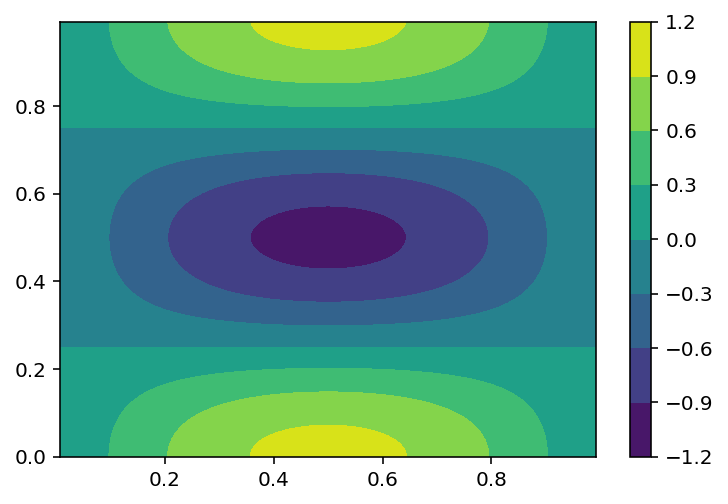

In [28]:
cs = plt.contourf(X,Y,U)
cb = plt.colorbar(cs)

# References
* [F2py](http://scipy.github.io/old-wiki/pages/F2py)
* [Fortran extension for IPython](https://github.com/mgaitan/fortran_magic)
